In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import multiprocessing
import random
import numpy as np
import matplotlib.pyplot as plt


def get_data_loaders(batch_size, val_fraction=0.2):

    transform = transforms.ToTensor()

    num_workers = multiprocessing.cpu_count()

    # Get train, validation and test

    # Let's start with train and validation
    trainval_data = datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    # Split in train and validation
    # NOTE: we set the generator with a fixed random seed for reproducibility
    train_len = int(len(trainval_data) * (1 - val_fraction))
    val_len = len(trainval_data) - train_len
    print(f"Using {train_len} examples for training and {val_len} for validation")
    train_subset, val_subset = torch.utils.data.random_split(
        trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=val_subset, shuffle=False, batch_size=batch_size, num_workers=num_workers
    )

    # Get test data
    test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )
    print(f"Using {len(test_data)} for testing")

    return {
        'train': train_loader,
        'valid': val_loader,
        'test': test_loader
    }


def seed_all(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def anomaly_detection_display(df):

    df.sort_values(by='loss', ascending=False, inplace=True)

    fig, sub = plt.subplots()
    df['loss'].hist(bins=100)
    sub.set_yscale('log')
    sub.set_xlabel("Score (loss)")
    sub.set_ylabel("Counts per bin")
    fig.suptitle("Distribution of score (loss)")

    fig, subs = plt.subplots(2, 20, figsize=(20, 3))

    for img, sub in zip(df['image'].iloc[:20], subs[0].flatten()):
        sub.imshow(img[0, ...], cmap='gray')
        sub.axis("off")

    for rec, sub in zip(df['reconstructed'].iloc[:20], subs[1].flatten()):
        sub.imshow(rec[0, ...], cmap='gray')
        sub.axis("off")

    fig.suptitle("Most difficult to reconstruct")
    subs[0][0].axis("on")
    subs[0][0].set_xticks([])
    subs[0][0].set_yticks([])
    subs[0][0].set_ylabel("Input")

    subs[1][0].axis("on")
    subs[1][0].set_xticks([])
    subs[1][0].set_yticks([])
    _ = subs[1][0].set_ylabel("Reconst")

    fig, subs = plt.subplots(2, 20, figsize=(20, 3))

    sample = df.iloc[7000:].sample(20)

    for img, sub in zip(sample['image'], subs[0].flatten()):
        sub.imshow(img[0, ...], cmap='gray')
        sub.axis("off")

    for rec, sub in zip(sample['reconstructed'], subs[1].flatten()):
        sub.imshow(rec[0, ...], cmap='gray')
        sub.axis("off")

    fig.suptitle("Sample of in-distribution numbers")
    subs[0][0].axis("on")
    subs[0][0].set_xticks([])
    subs[0][0].set_yticks([])
    subs[0][0].set_ylabel("Input")

    subs[1][0].axis("on")
    subs[1][0].set_xticks([])
    subs[1][0].set_yticks([])
    _ = subs[1][0].set_ylabel("Reconst")


In [2]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [3]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=20)

100%|██████████| 9912422/9912422 [00:00<00:00, 95618771.65it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71635537.45it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24206576.05it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6743550.01it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


In [8]:
images, _ = next(iter(data_loaders['train']))

images.shape

torch.Size([20, 1, 28, 28])

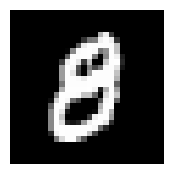

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2))
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 24, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(24, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 40, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(40),
            nn.MaxPool2d(2,2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(40, 24, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.ConvTranspose2d(24, 16, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 12, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.ConvTranspose2d(12, 8, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 1, 3, padding=1),
            nn.Sigmoid()
        )

        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):

        return self.model(x)


# initialize the NN
model = ConvDenoiser()

In [13]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [14]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):

    if torch.cuda.is_available():
        model = model.cuda()

    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in tqdm(
        desc="Training",
        total=len(data_loaders['train']),
        iterable=data_loaders['train'],
        ncols=80
    ):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data

        if torch.cuda.is_available():
            images = images.cuda()

        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.rand_like(images)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)

        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid'],
        ncols=80):
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data

            if torch.cuda.is_available():
                images = images.cuda()

            ## add random noise to the input images
            noisy_imgs = images + noise_factor * torch.rand_like(images)
            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

            ## forward pass: compute predicted outputs by passing *noisy* images to the model
            outputs = model(noisy_imgs)
            # calculate the loss
            # the "target" is still the original, not-noisy images
            loss = criterion(outputs, images)

            # update running training loss
            val_loss += loss.item()*images.size(0)

    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 172.46it/s]


Epoch: 1 	Training Loss: 0.396325	Valid Loss: 0.224421


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 167.73it/s]


Epoch: 2 	Training Loss: 0.192744	Valid Loss: 0.177010


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 164.64it/s]


Epoch: 3 	Training Loss: 0.166298	Valid Loss: 0.156047


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 171.73it/s]


Epoch: 4 	Training Loss: 0.153936	Valid Loss: 0.148335


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 171.81it/s]


Epoch: 5 	Training Loss: 0.146333	Valid Loss: 0.143124


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 161.23it/s]


Epoch: 6 	Training Loss: 0.140600	Valid Loss: 0.146157


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 173.32it/s]


Epoch: 7 	Training Loss: 0.135992	Valid Loss: 0.132299


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 150.63it/s]


Epoch: 8 	Training Loss: 0.132704	Valid Loss: 0.133898


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 165.79it/s]


Epoch: 9 	Training Loss: 0.129780	Valid Loss: 0.127171


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 173.35it/s]


Epoch: 10 	Training Loss: 0.127354	Valid Loss: 0.130545


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 165.42it/s]


Epoch: 11 	Training Loss: 0.125881	Valid Loss: 0.124214


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 171.27it/s]


Epoch: 12 	Training Loss: 0.123770	Valid Loss: 0.121794


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 172.67it/s]


Epoch: 13 	Training Loss: 0.122302	Valid Loss: 0.130882


Validating: 100%|████████████████████████████| 600/600 [00:04<00:00, 144.01it/s]


Epoch: 14 	Training Loss: 0.120963	Valid Loss: 0.120917


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 172.50it/s]


Epoch: 15 	Training Loss: 0.119709	Valid Loss: 0.118628


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 171.15it/s]


Epoch: 16 	Training Loss: 0.119264	Valid Loss: 0.118439


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 165.51it/s]


Epoch: 17 	Training Loss: 0.118059	Valid Loss: 0.116583


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 172.64it/s]


Epoch: 18 	Training Loss: 0.116953	Valid Loss: 0.115051


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 167.51it/s]


Epoch: 19 	Training Loss: 0.116121	Valid Loss: 0.123537


Validating: 100%|████████████████████████████| 600/600 [00:04<00:00, 142.76it/s]

Epoch: 20 	Training Loss: 0.115494	Valid Loss: 0.118051


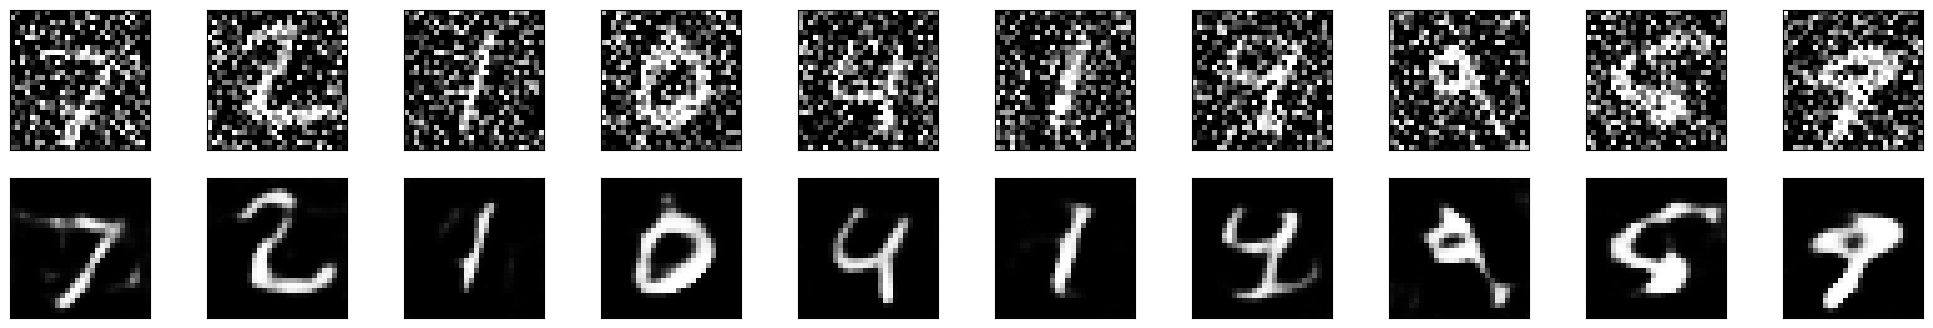

In [15]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])
images, labels = next(dataiter)

# add noise to the test images
noisy_imgs = images + 0.5 * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(20, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)